In [1]:
#Upload kaggle json file downloaded from kaggle here
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/face-mask-detection
! unzip face-mask-detection.zip

Saving kaggle.json to kaggle.json
 98% 391M/398M [00:04<00:00, 114MB/s] 
100% 398M/398M [00:04<00:00, 95.2MB/s]
Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: a

In [ ]:
!pip install tf-nightly
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from bs4 import BeautifulSoup
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
images_path = 'images'
labels_path = 'annotations'

In [4]:
#Considering mask worn incorrectly as with_mask
# 0- mask
# 1 - no mask
def generate_label(obj):
    if obj.find('name').text == "with_mask" or obj.find('name').text == 'mask_weared_incorrect':
        return 0
    return 1

In [5]:
labels = []
for label_path in sorted(os.listdir(labels_path)):
    xml_file = os.path.join(labels_path, label_path)
    with open(xml_file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        obj = soup.find('object')
        labels.append(generate_label(obj))

In [6]:
unique_labels, counts = np.unique(labels, return_counts=True)
print(unique_labels, counts)

[0 1] [734 119]


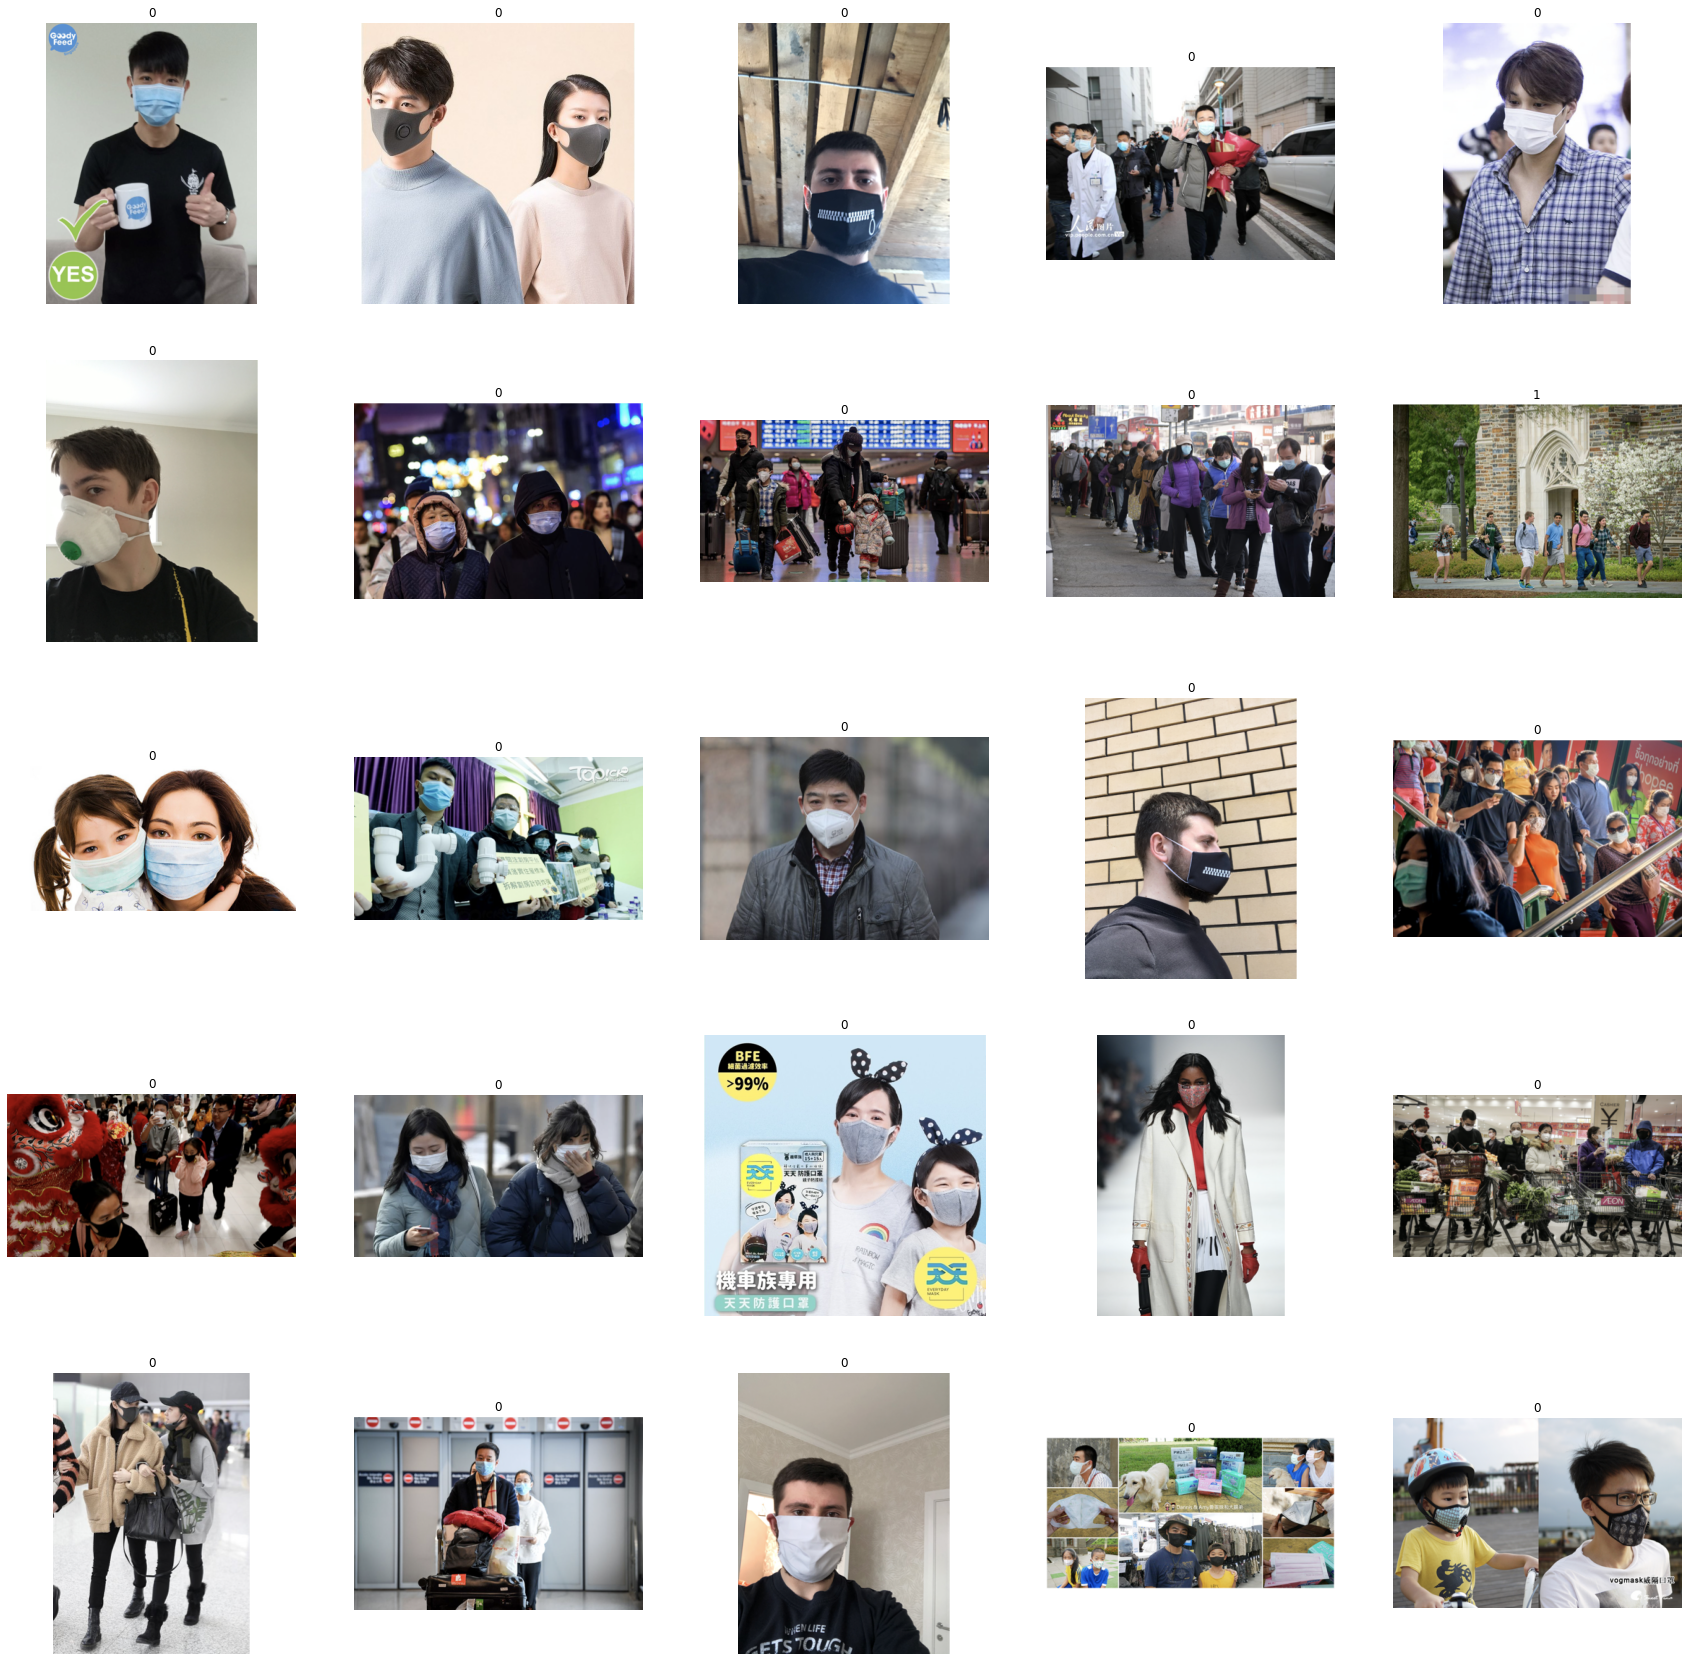

In [8]:
images = [plt.imread(os.path.join(images_path, img_path)) for img_path in sorted(os.listdir(images_path))]
nrows, ncols = 5, 5
figsize = [30, 30]    

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i, axi in enumerate(ax.flat):
    random_idx = random.randint(0, len(images)-1)
    img = images[random_idx]
    axi.set_title(labels[random_idx])
    axi.imshow(img)
    axi.axis('off')

plt.show()

In [ ]:
# w = []
# h = []
# for img in images:
#     w.append(img.shape[0])
#     h.append(img.shape[1])

# print(min(w), min(h), max(w), max(h))

In [9]:
!mkdir FaceMaskDataset
%cd FaceMaskDataset
!mkdir Mask
!mkdir NoMask
%cd /content

/content/FaceMaskDataset
/content


In [10]:
mask_path = 'FaceMaskDataset/Mask'
no_mask_path = 'FaceMaskDataset/NoMask'

In [11]:
IMG_PATHS = sorted(os.listdir(images_path))
for i in range(len(labels)):
    img = os.path.join(images_path, IMG_PATHS[i])
    if labels[i] == 0:
        shutil.copy(img, mask_path)
    elif labels[i] == 1:
        shutil.copy(img, no_mask_path)

In [ ]:
# masks = sorted(os.listdir(mask_path))
# nrows, ncols = 5, 5
# figsize = [30, 30]    

# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
# for i, axi in enumerate(ax.flat):
#     random_idx = random.randint(0, len(masks)-1)
#     img = plt.imread(os.path.join(mask_path, masks[random_idx]))
#     axi.set_title(labels[random_idx])
#     axi.imshow(img)
#     axi.axis('off')

# plt.show()

In [12]:
# 0 is mask and 1 is no mask 
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "FaceMaskDataset",
    validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "FaceMaskDataset",
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 853 files belonging to 2 classes.
Using 768 files for training.
Found 853 files belonging to 2 classes.
Using 85 files for validation.


In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(int(labels[i]))
#         plt.axis("off")

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     augmented_images = data_augmentation(images)
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [15]:
epochs = 10

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
24/24 [==============================] - 19s 812ms/step - loss: 0.4895 - accuracy: 0.8269 - val_loss: 0.6558 - val_accuracy: 0.7647
Epoch 2/10
24/24 [==============================] - 14s 590ms/step - loss: 0.4311 - accuracy: 0.8624 - val_loss: 0.6244 - val_accuracy: 0.7647
Epoch 3/10
24/24 [==============================] - 14s 577ms/step - loss: 0.3685 - accuracy: 0.8791 - val_loss: 0.5878 - val_accuracy: 0.7647
Epoch 4/10
24/24 [==============================] - 14s 579ms/step - loss: 0.4181 - accuracy: 0.8569 - val_loss: 0.5913 - val_accuracy: 0.7647
Epoch 5/10
24/24 [==============================] - 14s 579ms/step - loss: 0.3585 - accuracy: 0.8787 - val_loss: 0.5657 - val_accuracy: 0.7647
Epoch 6/10
24/24 [==============================] - 14s 580ms/step - loss: 0.3787 - accuracy: 0.8625 - val_loss: 0.5451 - val_accuracy: 0.7647
Epoch 7/10
24/24 [==============================] - 14s 588ms/step - loss: 0.3865 - accuracy: 0.8618 - val_loss: 0.5455 - val_accuracy: 0.7647

85.817% mask


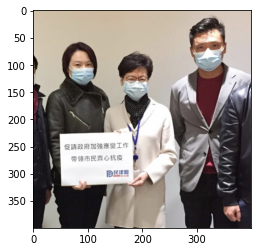

In [16]:
path = "images/maksssksksss812.png"
img = keras.preprocessing.image.load_img(path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0][0]
percent_mask =  100 * (1-score)  #cuz 0 means mask
print(f'{percent_mask:.3f}% mask')
img = plt.imread(path)
plt.imshow(img)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/My Drive'
%cd /content/drive/My\ Drive
!mkdir FaceMaskDataset
%cd FaceMaskDataset
!mkdir Mask
!mkdir NoMask

drive_mask_path = os.path.join(drive_path, mask_path)
for f in os.listdir(mask_path):
    shutil.copy(os.path.join(mask_path, f), drive_mask_path)


drive_no_mask_path = os.path.join(drive_path, no_mask_path)
for f in os.listdir(no_mask_path):
    print(f)
    shutil.copy(os.path.join(no_mask_path, f), drive_no_mask_path)


%cd /content

/content
